# EEMD + Prophet

## Data Description

    - Raw data: Historical Product Demand.csv

    - Input data: Data on 8x augmentation of demand records by selecting 8 representative items

    - Product code: 'Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
                    'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004'
            

    - Size of Data: 116392 rows × 4 columns

    - Features: Date, Product_Code, Product_Category, Order_Demand

    - Period: 2012-01-01 ~ 2017-01-09

---

In [28]:
# DataFrame
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Save the log
import os
import pickle

# Prophet 
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# EEMD
from PyEMD import EEMD

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

## Data Explore

In [29]:
# # Data Loading
# df = pd.read_csv('Data\HPD_0416.csv')
# # convert the string to the datetype
# df['Date'] = pd.to_datetime(df['Date'])
# # 범위 통일
# start_date = pd.to_datetime('2012-01-10')
# end_date = pd.to_datetime('2016-12-21')

# df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
# df = df.reset_index(drop=True)

In [75]:
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

In [30]:
df = pd.read_csv('Data\\train.csv')
df = df[(df['store']==1)]

pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())
df = df.reset_index(drop=True)
df.rename(columns={'date': 'Date', 'item':'Product_Code', 'sales':'Order_Demand'}, inplace=True)
df = df[['Date', 'Product_Code', 'Order_Demand']]
df['Date'] = pd.to_datetime(df['Date'])
df['Product_Code'] = df['Product_Code'].astype('str')

In [59]:
# print(df.info())
# print('-------------------------')
# print("")
# print("The Number of unique")
# print('-------------------------')
# print('Product code:\t', df.Product_Code.nunique())
# print('Category:\t', df.Product_Category.nunique())
# print('-------------------------')
# print("The Product Code:")
# print("")
# for i, code in enumerate(df['Product_Code'].unique()):
#     print(i+1, code)

---

## Split the data
- Input
     data: dataframe with dates and Demand data
     
- output
    - train:  2012-01-01 ~ 2015-06/30 
    - valid:  2015-07-01 ~ 2015-12-31
    - test :  2016-01-01 ~ 2017-01-06 
    
    
     
- time_steps: # of the input time steps 
- for_periods: # of the output time steps 

In [60]:
def split_data(df, test_ratio=0.1, valid_ratio=0.1):
    df = df.sort_values('ds')
    
    test_size = int(len(df) * test_ratio)
    valid_size = int(len(df) * valid_ratio)
    train_size = len(df) - test_size - valid_size

    train_df = df[:train_size]
    valid_df = df[train_size:train_size + valid_size]
    test_df = df[train_size + valid_size:]
    
    return train_df, valid_df, test_df

## EEMD
    - 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    - n 개의 eIMFs와  1개의 Residual 생성

In [61]:
def eemd_fit(df):
    # Define signal
    t = np.array(df['ds']) # x-axis
    s = np.array(df['y']) # y-axis
    
    # EEMD 객체 생성
    eemd = EEMD() # trials: EMD 횟수(default:100)
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'ds', df['ds']) # ds 열 추가
    
    # IMF & Residue 시각화
    plt.figure(figsize=(12, nIMFs*2)) # Figure size 설정
    for i in range(nIMFs):
        plt.subplot(nIMFs+1, 1, i+1) # i번째 subplot
        plt.plot(df['ds'], all_eIMFs_df[i], 'g')
        plt.title('IMF '+str(i+1), fontsize=10)

    # Residue plot
    plt.subplot(nIMFs+1, 1, nIMFs+1)
    plt.plot(df['ds'], all_eIMFs_df[nIMFs], 'r')
    plt.title('Residue', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [62]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # IMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['ds', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['ds', 'y'] # i -> y 로 열이름 변경
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
                           # df: ds, y 2열로 이루어진 dataFrame
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...} 

# EEMD+Prophet

### Optimize the hyper-parameters
    - Random Search

In [63]:
def optimize_prophet(eIMF_df, valid_df, optimize_trials):
    # 파라미터 후보
    param_grid = {  
        'changepoint_prior_scale': [0.01, 0.1, 1, 10],
        'seasonality_prior_scale': [0.01, 0.1, 1, 10],
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_range': [0.8, 0.9, 1.0],
        }
    
    # 파라미터 조합 생성
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  
    # 검증할 일 수 == len(valid_df)
    forecast_period = pd.to_datetime(valid_df['ds'].max()) - pd.to_datetime(valid_df['ds'].min()) + pd.Timedelta(days=1)
    cutoff = pd.to_datetime(valid_df['ds'].max()) - forecast_period
    # 랜덤 샘플링으로 50개의 조합 선택
    selected_params = random.sample(all_params, optimize_trials)
    
    # 파리미터 평가를 위해 validation_data로 cv진행
    for params in selected_params:
        m = Prophet(**params)
        m.add_country_holidays(country_name='US')  # 미국 공휴일 추가
        m.fit(eIMF_df)
        # validation 기간에 대해 예측
        df_cv = cross_validation(m, cutoffs=[cutoff], horizon=str(forecast_period.days)+' days')  
        # rolling_window: cut-off를 기준으로 몇 일의 성능을 계산할지 결정(1: 전체 기간동안의 성능)
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        
    best_params = selected_params[np.argmin(rmses)]
    return best_params

In [64]:
'''
eIMFs의 DataFrame을 하나씩 반복하면서,
Random search를 통해 Prophet 파라미터의 최적값을 찾고,
각 eIMFs들을 예측하고 예측 DataFrame을 Return
'''
def EEMD_Prophet(all_eIMFs_dict, optimize_trials): # optimize_trials: Search 횟수
    model_dict = {}
    pred_dict = {}
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        
        # 현재 eIMF 데이터 가져오기
        eIMF_df = all_eIMFs_dict[i]
        train_df, valid_df, test_df = split_data(eIMF_df)

        # Optimize params
        best_params = optimize_prophet(eIMF_df, valid_df, optimize_trials)
        
        predictions = []
        # Rolling Forecast
        for test_date in test_df['ds']:
            # Use data up to the day before the test date to train the model
            train_until_test_df = eIMF_df[eIMF_df['ds'] < test_date]
            
            # Train the model with the best parameters
            best_model = Prophet(**best_params)
            best_model.add_country_holidays(country_name='US')
            # 하루 전날 까지 fitting
            best_model.fit(train_until_test_df)
            
            # Predict the next day's value and add it to the predictions list
            future = best_model.make_future_dataframe(periods=1)
            prediction = best_model.predict(future)['yhat'].values[-1] 
            predictions.append(prediction)  

        # Create a DataFrame to hold the result
        res_df = test_df.copy()
        res_df['Pred'] = predictions
        res_df = res_df[['ds', 'y', 'Pred']]
        
        # 'y'와 'yhat' 열을 정규화
        scaler = MinMaxScaler()
        res_df[['y_norm', 'Pred_norm']] = scaler.fit_transform(res_df[['y', 'Pred']])
        res_df.set_index('ds', inplace=True)
            
        # 증강되지 않은 데이터와 비교 
        pred_dict[i] = res_df # res_df: ['y'','Pred','y_norm','Pred_norm'] index='ds'
        
        # 모델과 예측값 딕셔너리 반환
    return model_dict, pred_dict

## Total Result

In [65]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
    pred_df = all_df['Pred'].sum(axis=1)
    actual_df = all_df['y'].sum(axis=1)
    
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치
    
    # 날짜(Date) 열은 정규화하지 않으므로 제외
    result_norm = all_result_df[['Pred', 'y']]
    
    # MinMaxScaler를 이용하여 정규화
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(result_norm)
    
    # 정규화된 데이터를 데이터 프레임에 추가
    all_result_df['Pred_norm'] = normalized_data[:,0]
    all_result_df['y_norm'] = normalized_data[:,1]
    return all_result_df

# Plot the result

In [66]:
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, normalize=False):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "EEMD+Prophet_Result", product_code+f'_{today.month:02d}{today.day:02d}')
    if normalize: save_path += "_normalized"
        
    for i, pred_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-1})'s eIMF"
        actual = pred_df['y']
        pred = pred_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        if i == img_n-1: # All result
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'
        # 정규화 된 경우 actual, pred 값 달라짐
        if normalize:
            title += "(Normalized)"
            actual = pred_df['y_norm']
            pred = pred_df['Pred_norm']
            
        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(actual, label ='Actual', marker='o', ms=3)
        plt.plot(pred, label='Prediction', marker='o', ms=3)
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'))
    all_result_df.to_csv(os.path.join(save_path, f'{product_code}_Total_result.csv'))
    del pred_dict['all_result']
        
    plt.close('all') # close all figures to free up memory

## Metrics

In [67]:
# Model Metric
def mase(actual, pred, train):
    """
    actual: 실제 값이 저장된 1차원 배열
    pred: 예측 값이 저장된 1차원 배열
    train: 인-샘플 데이터(즉, 훈련 데이터)가 저장된 1차원 배열
    """
    actual, pred, train = np.array(actual), np.array(pred), np.array(train)
    n = len(actual)
    d = np.abs(actual - pred)
    d_naive = np.abs(train[1:] - train[:-1]).mean()  # train의 naive pred
    return d.mean() / d_naive

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [68]:
def calculate_metrics(pred_df, normalize):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])

    # 정규화 옵션이 True인 경우 정규화된 데이터 사용, 그렇지 않으면 원래 데이터 사용
    if normalize:
        actual = pred_df['y_norm']
        pred = pred_df['Pred_norm']
    else:
        actual = pred_df['y']
        pred = pred_df['Pred']

    # 메트릭 계산
    # MASE = mase(np.array(train_series), np.array(actual), pred) 
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)
    # RMSLE = mean_squared_log_error(actual, pred)**0.5 

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2':[round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

In [69]:
def make_metric_df(product_code, pred_dict, all_result_df, normalize):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df, normalize=normalize)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df, normalize=normalize)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) # 마지막 행은 all
    
    return metric_df

---

## Save and Load the model 

In [70]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/EEMD+Prophet_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return model_dict

In [71]:
# 학습된 모델 pickle파일에서 불러오기
def load_model(file_name):
    file_path = f'Result/EEMD+Prophet_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return model_dict

## Execute

In [72]:
def execute_EEMD_Prophet(product_code, optimize_trials=30):
    start_time = time.time()
    
    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product_Code']== product_code].reset_index(drop=True)
    # Prophet을 위해 열이름 변경 -> ['ds', 'y']
    product_df.rename(columns={'Date':'ds', 'Order_Demand':'y'}, inplace=True)
    
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df)
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)
    # EEMD+Prophet실행
    model_dict, pred_dict = EEMD_Prophet(all_eIMFs_dict, optimize_trials) #optimize trials
    all_result_df = make_all_result_df(pred_dict)
    
    # 모델 저장
    save_model(product_code, model_dict)
    # 결과 저장
    metric_df_norm = make_metric_df(product_code, pred_dict, all_result_df, True)
    metric_df      = make_metric_df(product_code, pred_dict, all_result_df, False)
    # plot 저장
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df_norm, True)
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df, False)
    
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력
    - ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
       'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

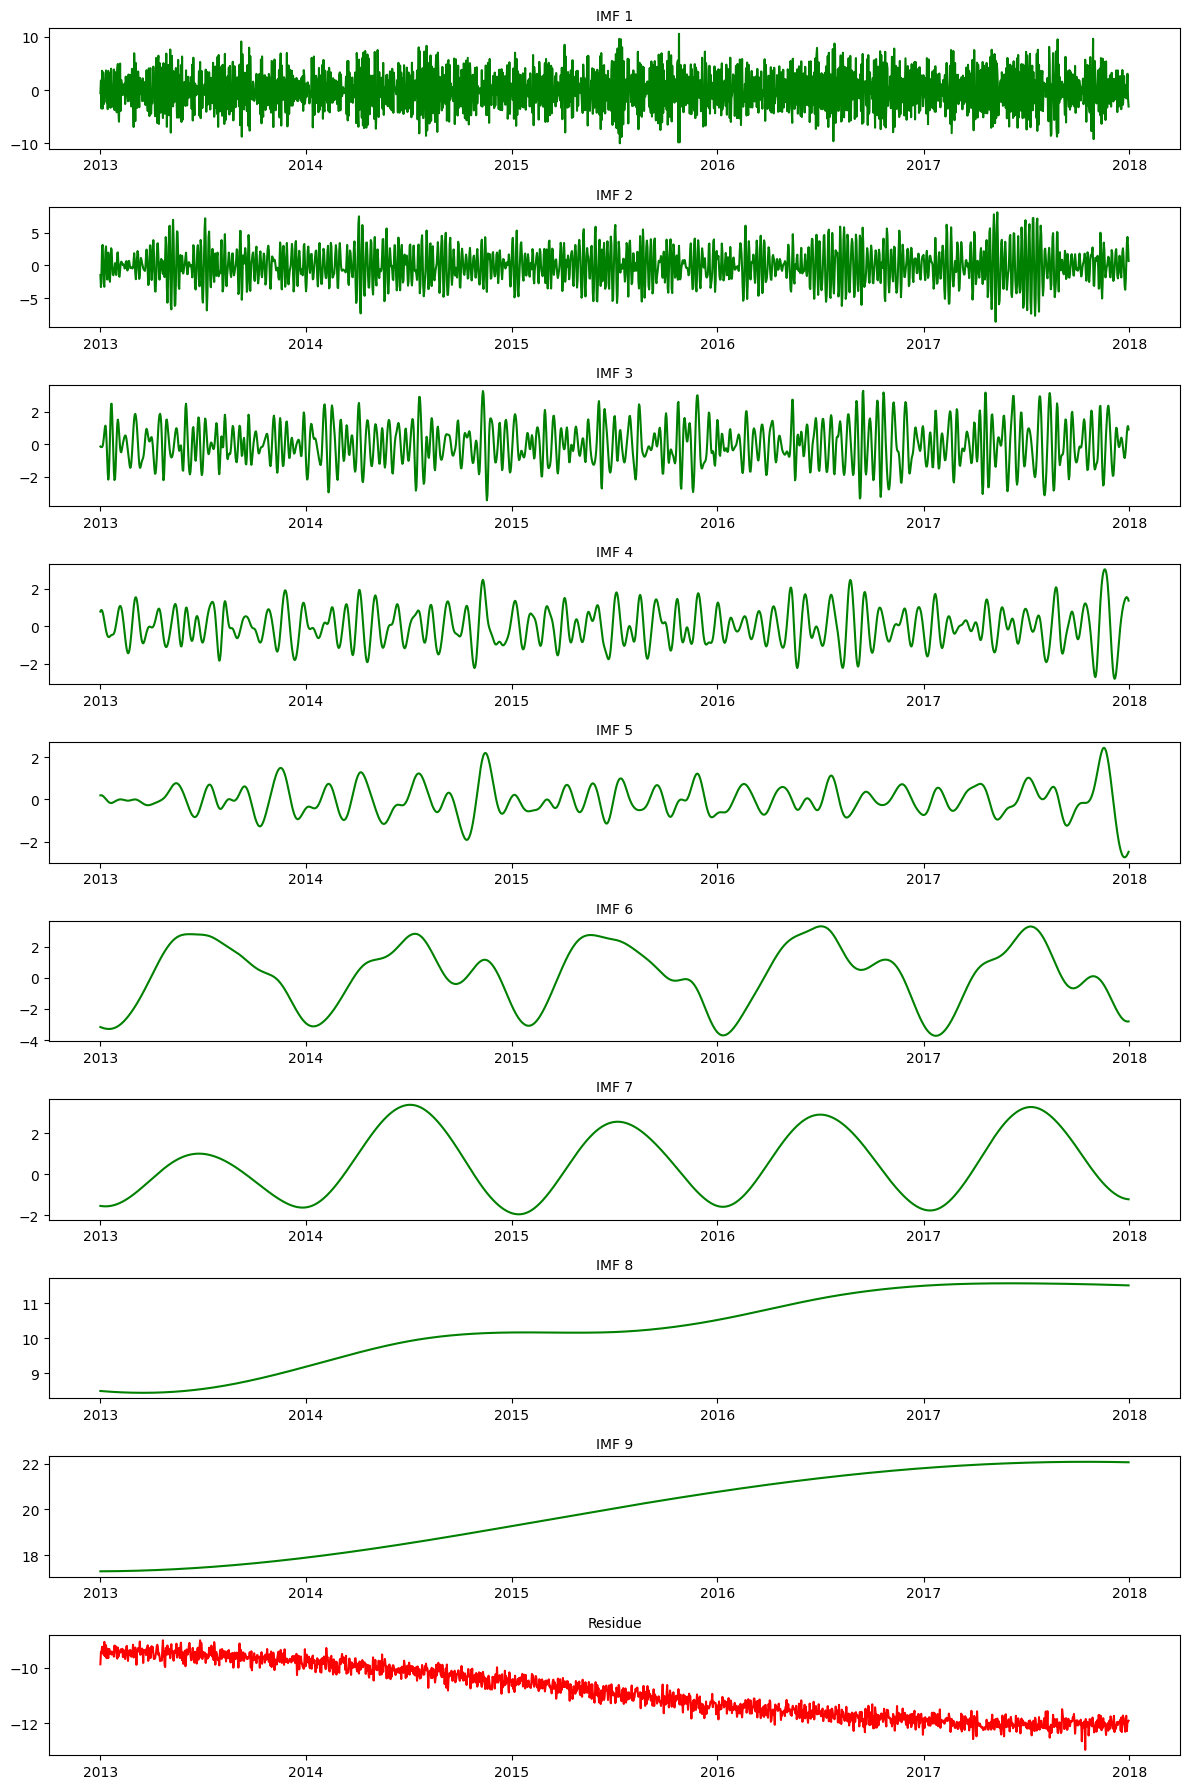

--------Total: 0~9 eIMFs, Now: eIMFs_0 --------


18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:24 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing
18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:25 - cmdstanpy - INFO - Chain [1] done processing
18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing
18:57:29 - cmdstanpy - INFO - Chain [1] start processing
18:57:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing
18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:33 - cmdstanpy - INFO - Chain [1] done processing
18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing
18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:35 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing
18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing
18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:42 - cmdstanpy - INFO - Chain [1] done processing
18:57:42 - cmdstanpy - INFO - Chain [1] start processing
18:57:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:44 - cmdstanpy - INFO - Chain [1] done processing
18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:46 - cmdstanpy - INFO - Chain [1] done processing
18:57:46 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:50 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1] done processing
18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing
18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:58:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
18:58:02 - cmdstanpy - INFO - Chain [1] start processing
18:58:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:58:04 - cmdstanpy - INFO - Chain [1] done processing
18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'product_df' is not defined

In [58]:
execute_EEMD_Prophet('4')

In [36]:
codes = ['1', '2', '3', '4', '5']

In [37]:
# codes = ['Product_0025', 'Product_0739', 'Product_0901', 'Product_1154',
#          'Product_1248', 'Product_1295', 'Product_1378', 'Product_2004']

In [38]:
for code in codes:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_Prophet(code)

========== 1 ==========
--------Total: 0~10 eIMFs, Now: eIMFs_0 --------


21:43:26 - cmdstanpy - INFO - Chain [1] start processing
21:43:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:27 - cmdstanpy - INFO - Chain [1] start processing
21:43:28 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:30 - cmdstanpy - INFO - Chain [1] start processing
21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:31 - cmdstanpy - INFO - Chain [1] start processing
21:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:31 - cmdstanpy - INFO - Chain [1] start processing
21:43:31 - cmdstanpy - INFO - Chain [1] done processing
21:43:32 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:32 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing
21:43:33 - cmdstanpy - INFO - Chain [1] start processing
21:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:33 - cmdstanpy - INFO - Chain [1] start processing
21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:34 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:44 - cmdstanpy - INFO - Chain [1] start processing
21:43:44 - cmdstanpy - INFO - Chain [1] done processing
21:43:44 - cmdstanpy - INFO - Chain [1] start processing
21:43:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:45 - cmdstanpy - INFO - Chain [1] start processing
21:43:45 - cmdstanpy - INFO - Chain [1] done processing
21:43:46 - cmdstanpy - INFO - Chain [1] start processing
21:43:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:46 - cmdstanpy - INFO - Chain [1] start processing
21:43:46 - cmdstanpy - INFO - Chain [1] done processing
21:43:47 - cmdstanpy - INFO - Chain [1] start processing
21:43:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:47 - cmdstanpy - INFO - Chain [1] start processing
21:43:47 - cmdstanpy - INFO - Chain [1] done processing
21:43:48 - cmdstanpy - INFO - Chain [1] start processing
21:43:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:48 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing
21:43:49 - cmdstanpy - INFO - Chain [1] start processing
21:43:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
21:43:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:52 - cmdstanpy - INFO - Chain [1] start processing
21:43:53 - cmdstanpy - INFO - Chain [1] done processing
21:43:53 - cmdstanpy - INFO - Chain [1] start processing
21:43:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:54 - cmdstanpy - INFO - Chain [1] start processing
21:43:54 - cmdstanpy - INFO - Chain [1] done processing
21:43:55 - cmdstanpy - INFO - Chain [1] start processing
21:43:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:55 - cmdstanpy - INFO - Chain [1] start processing
21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing
21:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:56 - cmdstanpy - INFO - Chain [1] start processing
21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing
21:43:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:57 - cmdstanpy - INFO - Chain [1] start processing
21:43:58 - cmdstanpy - INFO - Chain [1] done processing
21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:58 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing
21:43:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:43:59 - cmdstanpy - INFO - Chain [1] start processing
21:43:59 - cmdstanpy - INFO - Chain [1] done processing
21:44:00 - cmdstanpy - INFO - Chain [1] start processing
21:44:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:01 - cmdstanpy - INFO - Chain [1] start processing
21:44:02 - cmdstanpy - INFO - Chain [1] done processing
21:44:03 - cmdstanpy - INFO - Chain [1] start processing
21:44:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:03 - cmdstanpy - INFO - Chain [1] start processing
21:44:03 - cmdstanpy - INFO - Chain [1] done processing
21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:04 - cmdstanpy - INFO - Chain [1] start processing
21:44:04 - cmdstanpy - INFO - Chain [1] done processing
21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:05 - cmdstanpy - INFO - Chain [1] start processing
21:44:05 - cmdstanpy - INFO - Chain [1] done processing
21:44:06 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:08 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:09 - cmdstanpy - INFO - Chain [1] done processing


--------Total: 0~10 eIMFs, Now: eIMFs_1 --------


21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:11 - cmdstanpy - INFO - Chain [1] start processing
21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] done processing
21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:15 - cmdstanpy - INFO - Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:16 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1] start processing
21:44:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:19 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
21:44:21 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:21 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:23 - cmdstanpy - INFO - Chain [1] done processing
21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:24 - cmdstanpy - INFO - Chain [1] start processing
21:44:24 - cmdstanpy - INFO - Chain [1] done processing
21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:25 - cmdstanpy - INFO - Chain [1] start processing
21:44:25 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:26 - cmdstanpy - INFO - Chain [1] done processing
21:44:26 - cmdstanpy - INFO - Chain [1] start processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:27 - cmdstanpy - INFO - Chain [1] start processing
21:44:27 - cmdstanpy - INFO - Chain [1] done processing
21:44:28 - cmdstanpy - INFO - Chain [1] start processing
21:44:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:29 - cmdstanpy - INFO - Chain [1] start processing
21:44:30 - cmdstanpy - INFO - Chain [1] done processing
21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:31 - cmdstanpy - INFO - Chain [1] start processing
21:44:31 - cmdstanpy - INFO - Chain [1] done processing
21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:32 - cmdstanpy - INFO - Chain [1] start processing
21:44:32 - cmdstanpy - INFO - Chain [1] done processing
21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:33 - cmdstanpy - INFO - Chain [1] start processing
21:44:33 - cmdstanpy - INFO - Chain [1] done processing
21:44:34 - cmdstanpy - INFO - Chain [1] start processing
21:44:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:34 - cmdstanpy - INFO - Chain [1] start processing
21:44:34 - cmdstanpy - INFO - Chain [1] done processing
21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:35 - cmdstanpy - INFO - Chain [1] start processing
21:44:35 - cmdstanpy - INFO - Chain [1] done processing
21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:36 - cmdstanpy - INFO - Chain [1] start processing
21:44:36 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing
21:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:39 - cmdstanpy - INFO - Chain [1] start processing
21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:44 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing
21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:47 - cmdstanpy - INFO - Chain [1] start processing
21:44:47 - cmdstanpy - INFO - Chain [1] done processing
21:44:48 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing
21:44:50 - cmdstanpy - INFO - Chain [1] start processing
21:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing
21:44:51 - cmdstanpy - INFO - Chain [1] start processing
21:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing
21:44:52 - cmdstanpy - INFO - Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing
21:44:53 - cmdstanpy - INFO - Chain [1] start processing
21:44:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing
21:44:54 - cmdstanpy - INFO - Chain [1] start processing
21:44:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:55 - cmdstanpy - INFO - Chain [1] done processing
21:44:55 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


--------Total: 0~10 eIMFs, Now: eIMFs_2 --------


21:44:56 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:57 - cmdstanpy - INFO - Chain [1] done processing
21:44:57 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:58 - cmdstanpy - INFO - Chain [1] start processing
21:44:58 - cmdstanpy - INFO - Chain [1] done processing
21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:44:59 - cmdstanpy - INFO - Chain [1] start processing
21:44:59 - cmdstanpy - INFO - Chain [1] done processing
21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:00 - cmdstanpy - INFO - Chain [1] start processing
21:45:00 - cmdstanpy - INFO - Chain [1] done processing
21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:01 - cmdstanpy - INFO - Chain [1] start processing
21:45:01 - cmdstanpy - INFO - Chain [1] done processing
21:45:02 - cmdstanpy - INFO - Chain [1] start processing
21:45:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:03 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing
21:45:05 - cmdstanpy - INFO - Chain [1] start processing
21:45:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing
21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing
21:45:07 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing
21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:08 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing
21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:09 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing
21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing
21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing
21:45:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:15 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:16 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1] done processing
21:45:18 - cmdstanpy - INFO - Chain [1] start processing
21:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:19 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] start processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:21 - cmdstanpy - INFO - Chain [1] start processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:22 - cmdstanpy - INFO - Chain [1] start processing
21:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:22 - cmdstanpy - INFO - Chain [1] start processing
21:45:22 - cmdstanpy - INFO - Chain [1] done processing
21:45:23 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:25 - cmdstanpy - INFO - Chain [1] start processing
21:45:25 - cmdstanpy - INFO - Chain [1] done processing
21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:26 - cmdstanpy - INFO - Chain [1] start processing
21:45:26 - cmdstanpy - INFO - Chain [1] done processing
21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:27 - cmdstanpy - INFO - Chain [1] start processing
21:45:28 - cmdstanpy - INFO - Chain [1] done processing
21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:28 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing
21:45:29 - cmdstanpy - INFO - Chain [1] start processing
21:45:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:30 - cmdstanpy - INFO - Chain [1] start processing
21:45:30 - cmdstanpy - INFO - Chain [1] done processing
21:45:30 - cmdstanpy - INFO - Chain [1] start processing
21:45:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:31 - cmdstanpy - INFO - Chain [1] start processing
21:45:31 - cmdstanpy - INFO - Chain [1] done processing
21:45:31 - cmdstanpy - INFO - Chain [1] start processing
21:45:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:32 - cmdstanpy - INFO - Chain [1] start processing
21:45:32 - cmdstanpy - INFO - Chain [1] done processing
21:45:32 - cmdstanpy - INFO - Chain [1] start processing
21:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:33 - cmdstanpy - INFO - Chain [1] done processing
21:45:33 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing


--------Total: 0~10 eIMFs, Now: eIMFs_3 --------


21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:41 - cmdstanpy - INFO - Chain [1] start processing
21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:42 - cmdstanpy - INFO - Chain [1] start processing
21:45:42 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [ ]:
# 모델 로드
#load_model('Product_0739_0503.pkl')